## ACM SIGCHI Summer School on Computational Interaction
#### Inference, optimization and modeling for the engineering of interactive systems
#### 12-17 June 2017
##### Lucerne, Switzerland, ETH Zurich
-----

# Probabilistic filtering I
#### Inferring user intention in a noisy world
<b>[John Williamson](http://johnhw.com)</b> 
----

    All theorems are true. 
    All models are wrong. 
    And all data are inaccurate. 

    What are we to do? 
    We must be sure to remain uncertain.

-- *[Leonard A. Smith, Proc. International School of Physics ``Enrico Fermi", (1997)](http://www2.maths.ox.ac.uk/~lenny/fermi96_main_abs.html)* 

In [2]:
# import the things we need
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pykalman
import ipywidgets
import IPython
import matplotlib, matplotlib.colors
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
%matplotlib inline
from scipy.stats import norm
import scipy.stats

# Introduction 

-----------------
### What are we going to do?
We will:
* show how to represent interaction problems as inference;
* discuss how probabilistic filters can be used to attack these inference problems;
* discuss two different approaches to probabilistic filtering: Kalman filters and probabilistic filters, and the assumptions each model makes.
* specifically show how motion-based interfaces can use probabilistic filtering to increase robustness.


### What will we *practically* do?
* We will build a model that can track and predict mouse movements using an unscented Kalman filter, even as noise levels increase and observations become intermittent.

* We will build a 2D mouse gesture recognizer using a hybrid discrete/continuous particle filter. This will be a simple, robust classifier with rich feedback opportunities.

<img  src="imgs/capture.png" width="80%"/>



------

#### What is probabilistic filtering ?
One view on interaction is to see user intentions as **unknown values** which are partially observed through input sensors. The time series of inputs from the user only give a partial, noisy, incomplete view of intention inside the user's head. 

Probabilistic filtering **(PF)** tracks the evolution of some unknown variables *[user intentions]* given observed evidence *[user input]*, in a way that is **robust**. Probabilistic filters infer a **distribution** over possible hidden (unobserved) variables, updating them over time. These filters are inherently **uncertain**, as they represent degrees of belief, and **dynamic**, as they explicitly model changing state over time.

<img src="imgs/brain_inference.png">

#### Simulation viewpoint
These filters are really *simulators*. They *simulate* how possible user behaviors might unfold over time. In some probabilistic filters, hundreds of parallel simulators are run, each with slightly different parameters. In all cases, the simulations are adjusted online to better match observed reality. The internal parameters that drive the simulation are the *unknown variables* we want to infer and the *evidence* is the observed reality that adjusts the simulation parameters.

#### Properties
Probabilistic filtering is:

| Property | Why  |
|----------|------|
|**Bayesian**  |  Represents degrees of belief using probability distributions.    |
|**predictive**  |  Works by comparing predictions with reality.   |
|**generative** |  Involves generating (i.e. simulating) behavior.   |

-----
Probabilistic filtering is an **inverse probability** approach, and it requires that we think of interaction from an unique perspective. We have to explicitly be able to write down:

* what we want to know (i.e. the **state space of intention**);
* how that will change over time (i.e. the **dynamics of intention**);
*  a model that *if we knew what the user intention was, what the expected behavior would be* (i.e. a **generative function mapping intention -> expected user inputs**).

Note that this last point is the **inverse** of the typical way of approaching this problem, where we would try and find a mapping from a sensors to intention, by design or by learning. 

### Why is this computational HCI?
Probabilistic filtering means writing down an **executable, statistical model** of user behavior, then **running an inference algorithm** that updates beliefs based on the way observations evolve. The **parameters** of the filter can be **learned from user data**. The effectiveness of the filter can be quantitatively measured.

### What are competitive approaches?
#### **Crafted mappings**
**where we try to find (by hand) transforms from sensors to intentions that are  simple or obvious.**

**Example:** a button, which has two physical states, and maps on to two intentional states via two electrical states. Pushed down = current flows = user intended to switch on. The mapping from electrical states to intentional states is **designed.**
<img src="imgs/undo.jpg">
*[Image credit: David Singleton via flickr.com CC-BY 2.0]*

#### **Machine learned mappings**
**where we train a system to recognize a class of input patterns as being representative of an intended behavior. **
**Example:** Finger gesture recognizer; hundreds of examples of many users performing one of N multi-touch gestures are recorded. These are used to train a random forest to classify the intended gesture. The mapping from electrical states (capacitive sensors) to intentional states is **learned**.

<img src="imgs/svm.jpg" width="300px">
*[Image credit: Elisfm - via Wikimedia Commons; public domain]*

### Benefits
* **Robustness to noise** PFs work well even with input sensors that are noisy.
* **Robustness to poorly specified models** PFs can cope predictably even if our models are bad.
* **Robustness to intermittence** PFs can continue to sensibly interpolate when input cuts out.
* **Uncertainty estimates** PFs *know how certain they are* and this can be used in the interaction design.
* **Decoupled from real-time** PFs can infer past (smoothing), present (filtering) and future (forecasting).
* **Inherent fusion of multiple input sensors** PFs are often used to solely to fuse together multiple inputs from different sensors.
* **Better feedback** PFs  offer the opportunity to give users rich insight into the process of intention decoding.
* **Flexible modeling** PFs can incorporate both fundamental modeling (e.g. physiological or cognitive models) and data-driven machine learning.

# Principles 
-------

> Interaction is the process of driving a system into a state compatible with user intentions.

There are many perspectives on interaction from this stance, including:

| Perspective   | Burden | Characteristic                         |
|---------------|--------|----------------------------------------|
| Communication | User   | User gets information into the system, by encoding intentions. |
| Control       | Split  | User drives state towards intention via feedback control.   |
| Inference     | System | System infers what user intention is from sensed user actions. |

### Interaction as inference
If we view interaction as inference of intention, there are three elements:
* **Interaction is inference**; it is the process of inferring a hidden variable: what the user wants a system to do. 
* **Observations are noisy and incomplete** What a system sees is a distorted and incomplete representation of user actions in the world, which are in turn a noisy representation of internal intentions (your hand does not always go where you want it...)
* **Interaction occurs over time** Interaction is a *process* that evolves over time. Information flow is not instantaneous.

<img src="imgs/brainspace.png" width="100%">

### Overview diagram



<img src="imgs/control_loop.png">



Notation:
* We have a sequence of states over time, indexed by $t$
* $X_t$ the variable we want to know (at time $t$) (e.g. an intention inside a user's head). 
* $Y_t$ the variable we can observe (e.g. a sensor we can get readings from).
* For computational simplicity, we assume **discrete time**, i.e. we observe sensors in a discrete, regularly sampled way.

* We want to compute $P(X_t|Y_t)$ (the **inverse problem**). 
* We use a **forward model** $P(Y_t|X_t)$ to infer this.
* We need to define two functions: ${\bf\hat{y_t}} = f({\bf \hat{x}}_t)$ (the **observation function**) and $\hat{\bf x}_{t} = g(\hat{\bf x}_{t-1})$ (the **dynamics** or **process function**).
* We also need to compute the likelihood of the real observation given our model: $p(\bf\hat{y_t}|{\bf y_t})$.


* $f$, $g$ are often very simple functions.

<img src="imgs/stochastic.png" width="75%">

#### Predictor-corrector
**This is a predictor-corrector model**; the dynamics model supplies predictions, and corrections to those predictions are applied by the observation model.

## Recursive filtering

<img src="imgs/recursive.png">

Probabilistic filters are sometimes called **recursive Bayesian filters**. 
* They are **Bayesian** because they represent belief about states via probability distributions.
* They are **recursive** because they take a *prior*, condition on *evidence* and compute a *posterior*; this *posterior* then becomes the *prior* at the next time step.

As well as straightforward conditioning on observed evidence, probabilistic filters incorporate dynamics which form predictions of the world at the next time step.


## The problem
We want to track the position of a cursor.

We will take the case of a mouse (or touchpad). A mouse is usually very reliable and outputs data that is easy to reconstruct into a cursor trajectory; just integrate up the average flow vector seen by the optical sensor.

[img]

We will simulate some of the issues that might happen with less reliable sensors, such as tracking an coloured object with a camera-based system. This means we might encounter: 
* **noise**: continuous random variations
* **dropout**: complete loss of measurement
* **glitches**: random spikes of sensing that are not due to intentional movement.

## The cursor problem

In [ ]:

import noise_cursor
noise_cursor = reload(noise_cursor)
from noise_cursor import NoiseCursorDemo

In [79]:
# no noise
n = NoiseCursorDemo()        
%gui tk

Exiting...


In [80]:
# some noise
n = NoiseCursorDemo(noise=20)        
%gui tk

Exiting...


## Why not just smooth things with a simple linear filter?

In [82]:
def mk_lowpass(alpha):
    state = [0,0]
    def update(x,y):
        if x==x and y==y: # nan test
            state[0] = alpha*state[0] + (1-alpha)*x
            state[1] = alpha*state[1] + (1-alpha)*y
        return list(state)
    return update
    


In [87]:
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.95), noise=20)        
%gui tk

Exiting...


In [90]:
# what about some erratic jumps (e.g. mistracks)
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.95), noise=20, jump=0.05, jump_scale=2000)        
%gui tk

Exiting...


In [93]:
# and some tracking losses
n = NoiseCursorDemo(filter=mk_lowpass(alpha=0.95), noise=20, 
                    jump=0.05, jump_scale=2000, 
                    dropout=[0.02, 0.03])        
%gui tk

Exiting...


## Maybe we need a better filter?
The 1Euro filter, from [Casie et. al (CHI 2012)](http://cristal.univ-lille.fr/~casiez/acm.php?id=N05397) is an adaptive (nonlinear) filter for noisy cursor tracking.

In [119]:
from oneeurofilter import OneEuroFilter


In [120]:
def mk_oneuro(*args, **kwargs):
    filters = [OneEuroFilter(*args, **kwargs),OneEuroFilter(*args, **kwargs)]
    state = [0,0]
    def update(x,y):
        if x==x and y==y: # nan test
            state[0] = filters[0](x)
            state[1] = filters[1](y)            
        return list(state)
        
    return update

In [125]:
# and some tracking losses
n = NoiseCursorDemo(filter=mk_oneuro(freq=1.0, mincutoff=0.001, beta=0.001), noise=20)

Exiting...


In [117]:
# with dropout and mistracks
n = NoiseCursorDemo(filter=mk_oneuro(freq=1.0, mincutoff=0.001, beta=0.001), noise=20, 
                    jump=0.05, jump_scale=2000, 
                    dropout=[0.02, 0.03])        
%gui tk

Exiting...


### The task
We want to recover the **intended position** of the cursor from the observed sensing.

* That is, we have $\bf x_t$ be the **intended position** of the cursor at $t$ (this is the hidden variable we wish to estimate). The intended position exists in the user's head.
* We have $\bf y_t$, the observation made at time $t$, which might be the displacement vector the OS reports in our example. 

We need to write down our model explicitly:

* **State space for $\bf x_t$**. $\bf x_t$ is our belief about intended location. It obviously has at least two coordinates giving an intended location in screen space. But we can do a better job at predicting motion if we assume some predictable smooth *dynamics* of the cursor. In particular, we can assume that there is some associated **velocity** and **acceleration** of the cursor, and at each time point time, $\bf{x_t} = [x_t, y_t, \dot{x}_t, \dot{y}_t, \ddot{x}_t, \ddot{y}_t]$.
($\dot{x}$ means the first time derivative of $x$, $\ddot{x}$ means the second time derivative of $x$).
* **State space for $Y_t$** $Y_t$ is given by our sensor configuration. The OS reports two position offsets since the last observation, $\delta x_t$ and $\delta y_t$ at each observation. So $\bf{y_t} = [\delta x_t, \delta y_t]$
* **Prior** *where would we believe the cursor to be if we had made no measurement? *
We can assume the cursor is intended to be somewhere on screen. Beyond that, we might not have any guesses as to where the cursor might be. We could be clever and assume that the cursor is likely to be near targets of interest (e.g. close to menu headers), but for now, we will assume a simple uniform prior. We can assume a simple normal distribution on velocity and acceleration.

$$X_0 \approx [U(0,x_{max}), U(0,y_{max}), N(0, \sigma_v), N(0, \sigma_v), 
N(0, \sigma_a), N(0,\sigma_u)],$$
where $\sigma_v$ is scales the expected velocity and $\sigma_a$ scales the expected acceleration.

* **Dynamics** *given a current estimate of intended position, where would we expect the next intended position to be?*
We would assume that the cursor is near where it was, but is moving smoothly some velocity and acceleration: after all, it is the result of a physical motion in the world and thus has second-order dynamics.
* **Observation** *given our estimate of intended position, what observations would we expect?*
We'll assume that the velocity of the cursor gives us the frame-by-frame delta in mouse position. The observation is assumed to be a noisy representation of the true velocity.

* **Likelihood** given an observation, how probable is it under compared to our expected observations? 

## The Kalman filter
### Assumptions
#### Normality of all distributions
The Kalman filter approximates all distributions as normal (Gaussian) distributions.
This includes:
* the *process noise*, i.e. the stochastic part of the dynamics
* the *observation noise*, i.e. the noise in the observation process
* the current *state* of the filter
* the *likelihood* of the observation given the current state

All of these are Gaussian and characterised by a **covariance matrix** $\Sigma$ which specifies the shape of the distribution; it can be seen as defining the shape of the ellipsoidal isosurfaces of the distribution.

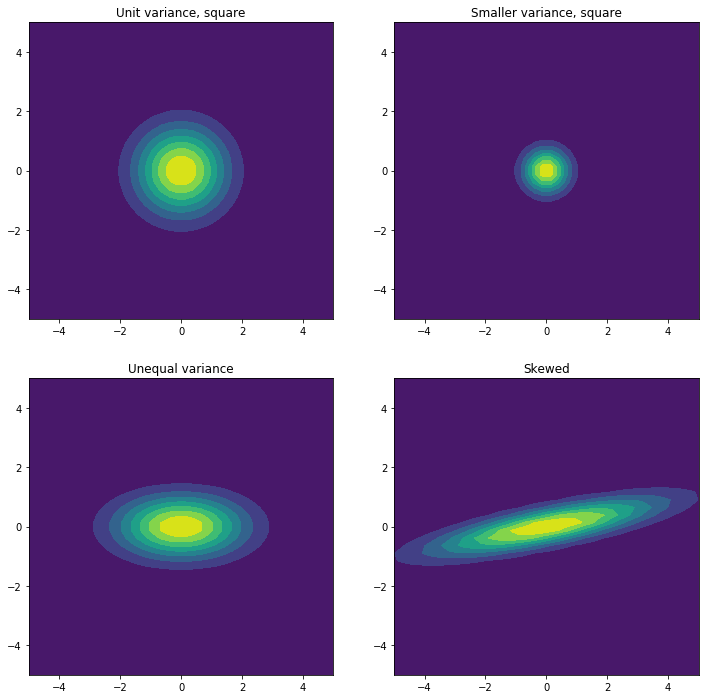

In [127]:
## A selection of different possible shapes of 2D Gaussians

def sigma_plot(sigma):
    mx = np.linspace(-5,5,40)
    x, y = np.meshgrid(mx,mx)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = scipy.stats.multivariate_normal([0,0], sigma)
    plt.contourf(x, y, rv.pdf(pos))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sigma_plot([[1,0], [0,1]])    
plt.title("Unit variance, square")
plt.subplot(2,2,2)
sigma_plot([[0.25,0], [0,0.25]])    
plt.title("Smaller variance, square")
plt.subplot(2,2,3)
sigma_plot([[2,0], [0,0.5]])    
plt.title("Unequal variance")
plt.subplot(2,2,4)
plt.title("Skewed")
sigma_plot([[6,0], [1.2,0.4]])    
    

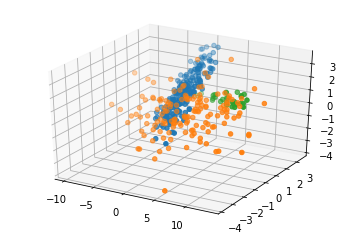

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cluster_1 = np.random.normal(np.array([0,1,2]), np.array([1,1,1]), size=(200,3))
cluster_2 = np.random.normal(np.array([2,0,0]), np.array([5,1,0.5]), size=(150,3))
cluster_3 = np.random.normal(np.array([7,1,1]), np.array([1.8,0.2,0.5]), size=(30,3))

for cluster in [cluster_1, cluster_2, cluster_3]:
    x = cluster[:,0]
    y = cluster[:,1]
    z = cluster[:,1]
    ax.scatter(x,y,z)

plt.savefig("plot3d.svg")

#### Linearity of dynamics
The Kalman filter, in its basic form, assumes that all dynamics are **linear**. That is, our next guess of $X_{t+1} = Ax_t$; the transformation from the previous state to the next must be expressible as a simple matrix multiplication.

For example, basic second-order of a point can be written as a discrete time linear system:

$$X_t = [x_t, \dot{x_t}, \ddot{x_t}]$$
$$A = \begin{bmatrix}
1 & \Delta T & \frac{1}{2}\Delta T^2\\
0 & 1& \Delta T\\
0 & 0& 1\\ 
\end{bmatrix}$$
$$X_{t+1} = A{\bf x_t}$$

Note that the Kalman filter does not require $A$ to be the same at each timestep; we can have a time-varying $A_t$ which is different at each time step. This can be used to **locally** linearise a system with nonlinear global dynamics (i.e. to use a new linear approximation at each new timestep).

## Why?
These restrictions are quite limiting, but because:
* every linear transformation of a Gaussian is Gaussian and
* every product of two Gaussians is also Gaussian,

the Kalman filter can maintain the full probabilistic state and perform all of its updates just by updating the parameters of a multivariate Gaussian. This is very computationally and inferentially efficient: it is quick to do, and the estimates can be very good even with limited data, *as long* as the problem at hand is reasonably modeled with these assumptions.

# Building a cursor Kalman filter

### Model structure

Let's first assume we only have a 2D position, velocity and acceleration, so our state space is $[x_t, y_t, \dot{x}_t, \dot{y}_t, \ddot{x}_t, \ddot{y}_t]$, and we can write some simple second order dynamics:

$$A = \begin{bmatrix}
1 & 0 & \Delta T & 0 & \frac{1}{2}\Delta T^2 & 0 \\
0 & 1 & 0 & \Delta T & 0 & \frac{1}{2}\Delta T^2  \\
0 & 0 & 1 & 0 & \Delta T & 0\\
0 & 0 & 0 & 1 & 0 & \Delta T\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$


We also assume that our dynamics have some **noise**; i.e. they are not fully deterministic. By the restrictions of the Kalman filter, this must be Gaussian (normally distributed noise), and it has a structure given by a **covariance matrix** $\Sigma_A$. We need to **specify** this covariance matrix (note that it can be *learned from data* as well).

We will assume the noise is uncorrelated, and is equal across $x$ and $y$, so the covariance looks like a diagonal matrix:

$$\Sigma_A = \begin{bmatrix}
\sigma_x & 0  & 0 & 0  & 0 & 0 \\
0 & \sigma_x  & 0 & 0  & 0 & 0 \\
0 & 0  & \sigma_{dx} & 0  & 0 & 0 \\
0 & 0  & 0 & \sigma_{dx} & 0 & 0 \\
0 & 0  & 0 & 0 & \sigma_{ddx} & 0 \\
0 & 0  & 0 & 0 & 0 & \sigma_{ddx} \\
\end{bmatrix}$$

and our whole dynamics equation is then just:

$$X_{t+1} = A{\bf x_t} + N(0,\Sigma_A) $$

We can write this in code:

In [57]:
sigma_x = 0.1
sigma_dx = 0.01
sigma_ddx = 0.001
sigma_a = np.diag([sigma_x, sigma_x, sigma_dx, sigma_dx, sigma_ddx, sigma_ddx])

dt = 0.01 # 1 / frame rate in some time units
dt2 = 0.5 * dt * dt
A = np.array([[1,0, dt,0, dt2,0],
     [0,1, 0,dt, 0,dt2],
     [0,0, 1,0, dt,0],
     [0,0, 0,1, 0,dt],
     [0,0, 0,0, 1,0],
     [0,0, 0,0, 0,1]])
print(sigma_a)
print(A)

[[ 0.1    0.     0.     0.     0.     0.   ]
 [ 0.     0.1    0.     0.     0.     0.   ]
 [ 0.     0.     0.01   0.     0.     0.   ]
 [ 0.     0.     0.     0.01   0.     0.   ]
 [ 0.     0.     0.     0.     0.001  0.   ]
 [ 0.     0.     0.     0.     0.     0.001]]
[[  1.00000000e+00   0.00000000e+00   1.00000000e-02   0.00000000e+00
    5.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e-02
    0.00000000e+00   5.00000000e-05]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    1.00000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00]]


In [58]:
def simple_simulate_dynamics(A, sigma_a, x=None, n=100):
    if x is None:
        x = np.zeros((A.shape[0],))
    xs = []
    for i in range(n):
        # x_{t+1} = A x_t + N(0, sigma_a)
        x = np.dot(A,x) + scipy.stats.multivariate_normal.rvs(cov=sigma_a)
        xs.append(x)
    return np.array(xs)

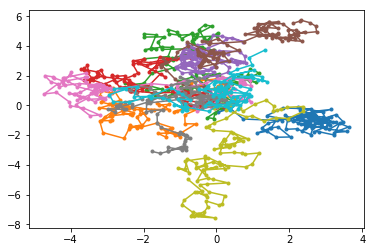

In [59]:
# some random walks with these dynamics
for i in range(10):
    xs = simple_simulate_dynamics(A, sigma_a)
    plt.plot(xs[:,0], xs[:,1], '.-')

In [ ]:
We can postulate alternative dynamics, and observe the effect

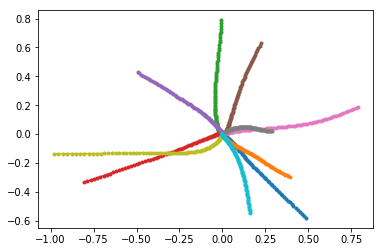

In [60]:
# Just acceleration; smooth trajectories
sigma_x = 0.0
sigma_dx = 0.0
sigma_ddx = 0.05
sigma_a2 = np.diag([sigma_x, sigma_x, sigma_dx, sigma_dx, sigma_ddx, sigma_ddx])
# some random walks with some alternative dynamics
for i in range(10):
    xs = simple_simulate_dynamics(A, sigma_a2)
    plt.plot(xs[:,0], xs[:,1], '.-')

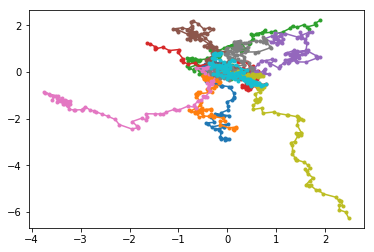

In [61]:
# no acceleration, strong velocity noise, weaker position noise
sigma_x = 0.01
sigma_dx = 0.2
sigma_ddx = 0.0
sigma_a3 = np.diag([sigma_x, sigma_x, sigma_dx, sigma_dx, sigma_ddx, sigma_ddx])
# some random walks with some alternative dynamics
for i in range(10):
    xs = simple_simulate_dynamics(A, sigma_a3)
    plt.plot(xs[:,0], xs[:,1], '.-')

## Observations
We need to be able to transform our internal state $\bf \hat{x_t}$ into the observation we would expect to see given that state. 

In this case, we assume that we'd expect to see a position equal to the position term of our state. We can again write this as a matrix $C$ (i.e. a linear projection from our internal state space to the observation):

$$C = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
\end{bmatrix}$$





In [74]:
C = np.array([[1,0,0,0,0,0], 
              [0,1,0,0,0,0]]).astype(np.float64)
print(C)

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]


We also know that our observation is **noisy** (i.e. not a true measurement of the world).
We can (again) use a Gaussian to represent the noise we expect to see, characterised by a covariance $\Sigma_c$. The following matrix assumes noises is equal on $x$ and $y$ and uncorrelated.

$$\Sigma_C = \begin{bmatrix}
\sigma_c & 0 \\
0 & \sigma_c \\
\end{bmatrix}$$

In [75]:
sigma_c = 0.1
Sigma_c = np.diag([sigma_c, sigma_c])
print(Sigma_c)

[[ 0.1  0. ]
 [ 0.   0.1]]


$\bf\hat{y_t} = C \bf\hat{x_t} + N(0, \Sigma_C)$